In [2]:
from netwin import *
import os, fnmatch
import matplotlib.pyplot as plt
from nilearn import plotting
import numpy as np
import pandas as pd
import matplotlib as mpl

%load_ext autoreload
%autoreload 2

### Create average ajacency matrix from individual subjects

In [3]:
result =[]
path = '/home/chaggar/Documents/Network_Inference/subjects/'
for root, dirs, files in os.walk(path):
    for name in files:
        if fnmatch.fnmatch(name, 'fdt_network_matrix'):
            result.append(os.path.join(root, name))


In [4]:
A_all = np.ones((83,83,10))
for i, j in enumerate(result):
    A_all[:,:,i] = np.genfromtxt(j)

In [5]:
A = np.mean(A_all,axis=2)

A = A / np.max(A)

SymA = (A + A.T)/np.max(A+A.T)

#### load network model using adjacency matrix

In [6]:
m = NetworkFKPP(A)

### Load coordinates for 83 node connectome

In [7]:
coordinate_path = '/home/chaggar/Documents/Network_Inference/data/mni_coordinates/mni-parcellation-scale1_coordinates.csv'

nodes = pd.read_csv(coordinate_path)

x, y, z = np.array(nodes.x), np.array(nodes.y), np.array(nodes.z)
coords = np.vstack((x, y, z))


In [8]:
alpha = np.linspace(0.7, 1, 258, endpoint=True)
degree_norm = np.diagonal(m.D()) / np.max(m.D())
node_colour = plt.cm.Blues(degree_norm, alpha)


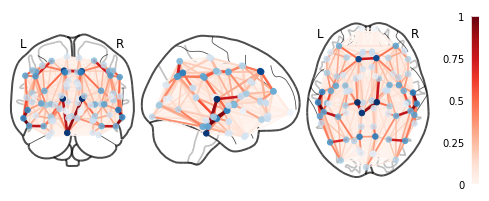

In [9]:
plotting.plot_connectome(node_coords=coords.T,adjacency_matrix=SymA, node_size = 30, colorbar=True, node_color=node_colour, alpha=0.5, edge_cmap='Reds', edge_vmin=0, edge_vmax=1)
plotting.show()

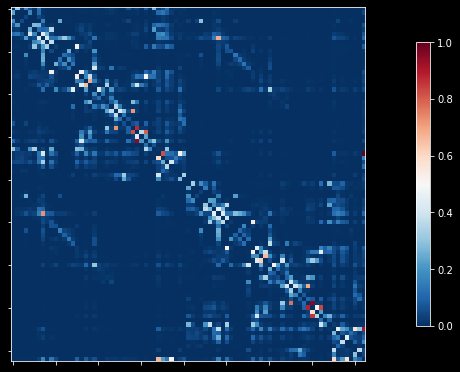

In [10]:
plotting.plot_matrix(A/np.max(A))
plotting.show()

### Setting up and running forward simulation

In [11]:
p = np.zeros([83]) + 1e-5
mask = [25, 26, 39, 40, 66, 67, 80, 81]
p[mask] = 0.1

k = 5
a = 10

m.t = np.linspace(0,1,100)

u0 = np.append(np.log(p), np.log([k, a]))

In [12]:
sim = m.forward(u0)

#### plotting forward simulation

In [13]:
alpha = np.linspace(0.7, 1, 258, endpoint=True)
p_conc = sim[40]/np.max(sim[40])
node_colour = plt.cm.Greens(p_conc, alpha)

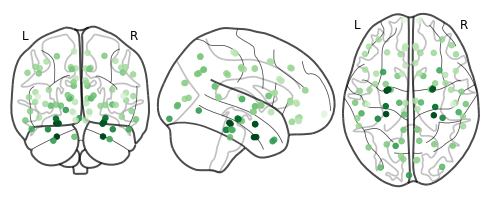

In [14]:
plotting.plot_connectome(node_coords=coords.T,adjacency_matrix=np.eye(83), node_size = 30, node_color=node_colour)
plotting.show()

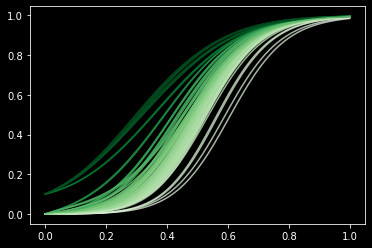

In [15]:
ax = plt.figure()

for i in range(len(sim[0])):
    #plt.plot(m.t)
    plt.plot(m.t, sim[:,i], c=node_colour[i])

ax.show()

### create noisy data from forward simulation

In [16]:
data = np.empty_like(sim)
for i in range(len(sim[0])):
    data[:,i] = sim[:,i] + (np.random.rand(len(sim[:,i]))/100)

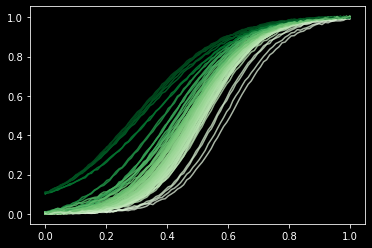

In [17]:
ax = plt.figure()

for i in range(len(data[0])):
    #plt.plot(m.t)
    plt.plot(m.t, data[:,i], c=node_colour[i])

ax.show()

## Inference

In [18]:
m = NetworkFKPP(A)

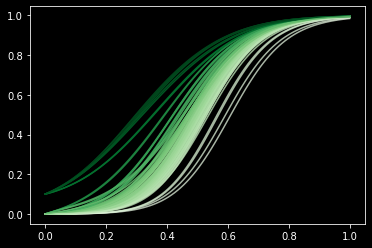

In [19]:
p = np.zeros([83])
mask = [25, 26, 39, 40, 66, 67, 80, 81]
p[mask] = 0.1
k = 5
a = 10

m.t = np.linspace(0,1,100)

u0 = np.append(np.log(p), np.log([k, a]))

sim = m.forward(u0)

ax = plt.figure()

for i in range(len(sim[0])):
    #plt.plot(m.t)
    plt.plot(m.t, sim[:,i], c=node_colour[i])

ax.show()

### set priors

In [67]:
p0 = np.zeros([83])
k0 = 0
a0 = 0
u_0 = np.append(p0, [k0, a0])

problem = InferenceProblem(inference='VB', model=m, data=data, init_means=u_0)

sol, F = problem.infer(n=20)

Iteration 0
-1188.7847664038843
Iteration 1
-1144.2066973838205
Iteration 2
-1096.8983136783083
Iteration 3
-1052.0847877593803
Iteration 4
-1020.2400916538828
Iteration 5
-980.9026178813684
Iteration 6
-957.1240169925845
Iteration 7
-924.2545617802981
Iteration 8
-906.4845516916655
Iteration 9
-876.1628460621962
Iteration 10
-865.0510693115324
Iteration 11
-832.6643026217204
Iteration 12
-831.3682035876803
Iteration 13
-792.0990114617656
Iteration 14
-805.2532054576624
Iteration 15
-755.6936277219742
Iteration 16
-785.4135864168495
Iteration 17
-725.897153474577
Iteration 18
-783.8899333368842
Iteration 19
-690.3437102862363
19
Finished!


In [68]:
np.exp(sol[0])

array([9.15540225e-03, 1.01519731e-02, 3.83255153e-03, 7.61346329e-03,
       9.50200740e-03, 7.91612328e-03, 1.05180287e-02, 8.59506234e-03,
       8.27598897e-03, 7.97065691e-03, 7.83619813e-03, 7.46919815e-03,
       7.85045089e-03, 8.64137081e-03, 1.27845575e-02, 8.51517942e-03,
       1.03199385e-02, 1.03521697e-02, 1.42456837e-02, 1.35923159e-02,
       9.77064635e-03, 9.96093348e-03, 1.53223609e-02, 2.06724528e-02,
       2.75800070e-02, 7.35195396e-02, 7.77451027e-02, 1.83877054e-02,
       1.78217752e-02, 1.13964261e-02, 9.63193396e-03, 1.29528153e-02,
       4.33566155e-03, 1.37878989e-02, 2.20365776e-02, 1.15839488e-02,
       9.52629219e-03, 1.05574823e-02, 7.90031636e-03, 5.20148564e-02,
       6.88826898e-02, 8.46026985e-03, 8.45095709e-03, 3.22971241e-03,
       6.97372716e-03, 8.49686347e-03, 8.62368621e-03, 9.44703058e-03,
       8.89956686e-03, 8.73708509e-03, 8.69532794e-03, 6.67933995e-03,
       7.26562211e-03, 7.21427722e-03, 8.36808208e-03, 1.30485192e-02,
      

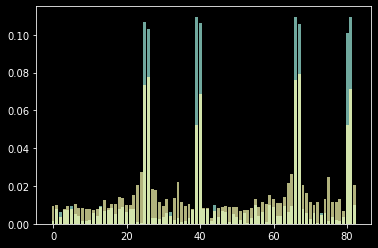

In [69]:
plt.bar(range(83), data[0], alpha=0.8)
plt.bar(range(83), np.exp(sol[0][:-2]), alpha=0.7)
plt.show()

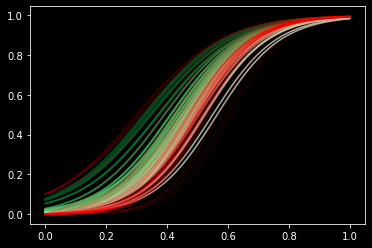

In [70]:
inferred = m.forward(sol[0])

ax = plt.figure()

for i in range(len(inferred[0])):
    #plt.plot(m.t)
    plt.plot(m.t, inferred[:,i], c=node_colour[i])

for i in range(len(sim[0])):
    #plt.plot(m.t)
    plt.plot(m.t, sim[:,i], c='r', alpha=0.1)

ax.show()